# Analysis of "Azerbaijani Laundromat" transaction data

## set up environment

Load the library dependencies

In [1]:
from collections import defaultdict
from datetime import datetime, timedelta
import itertools
import pathlib
import statistics
import typing

from icecream import ic
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import pyvis
import scipy
import seaborn as sns
import watermark

Show a watermark of the OS, hardware, language environment, and dependent library versions.

In [2]:
%load_ext watermark
%watermark
%watermark --iversions

Last updated: 2025-02-22T23:25:13.399293-08:00

Python implementation: CPython
Python version       : 3.13.2
IPython version      : 8.32.0

Compiler    : Clang 16.0.0 (clang-1600.0.26.6)
OS          : Darwin
Release     : 23.6.0
Machine     : arm64
Processor   : arm
CPU cores   : 14
Architecture: 64bit

seaborn   : 0.13.2
networkx  : 3.4.2
scipy     : 1.15.2
pandas    : 2.2.3
matplotlib: 3.10.0
watermark : 2.5.0
pyvis     : 0.3.2



Configure `pandas`

In [3]:
pd.set_option("display.max_rows", None)

## load the money transfer data

Load the OCCRP data for the "Azerbaijani Laundromat" leaked bank transactions <https://github.com/cj2001/senzing_occrp_mapping_demo/blob/main/occrp_17k.csv>

In [4]:
occrp_file: pathlib.Path = pathlib.Path("occrp_17k.csv")
df_orig: pd.DataFrame = pd.read_csv(occrp_file)

In [5]:
df_orig.head()

,payer_name,payer_jurisdiction,payer_account,source_file,amount_orig,id,beneficiary_type,beneficiary_core,amount_orig_currency,beneficiary_name,...,beneficiary_name_norm,payer_core,beneficiary_account,purpose,date,amount_usd,amount_eur,payer_type,payer_name_norm,payer_bank_country
0,AZARBAYCAN METANOL KOMPANI MMC,AZ,33817018409333311204,pdf/LCM ALLIANCE Account statement 30.06.12-31...,535470.00,6049,Company,True,USD,LCM ALLIANCE LLP,...,LCM ALLIANCE LLP,False,EE27 3300 3335 0561 0002,1206295100052180 OCT4121800021 ADVANCE PAYM FO...,2012-06-30,535470,"$431,762.31",Company,AZARBAYCAN METANOL KOMPANI MMC,33
1,LCM ALLIANCE LLP,GB,EE27 3300 3335 0561 0002,pdf/LCM ALLIANCE Account statement 30.06.12-31...,-535000.00,6050,Company,False,USD,MOBILA LLP,...,MOBILA LLP,True,333504500003,1207035026699176 INVOICE.No 6215 DD 25.05.2012,2012-07-03,535000,"$423,688.44",Company,LCM ALLIANCE LLP,EE
2,SKN ELECTRICAL SERVICES LIMITEDACCO,GB,20100374548222,pdf/METASTAR Account statement 30.06.12-31.12....,90535.19,10623,Company,True,USD,METASTAR INVEST LLP,...,METASTAR INVEST LLP,False,EE77 3300 3334 8704 0004,"1207065103089249 /FEE/USD4,81",2012-07-06,90536,"$71,698.53",Company,SKN ELECTRICAL SERVICES LIMITED,20
3,METASTAR INVEST LLP,GB,EE77 3300 3334 8704 0004,pdf/METASTAR Account statement 30.06.12-31.12....,-90520.00,15589,Company,False,USD,INMAXO CAPITAL CORP,...,INMAXO CAPITAL CORP.,True,333455870002,1207095022358525 DOGOVOR ZAYMA,2012-07-09,90520,"$71,686.50",Company,METASTAR INVEST LLP,EE
4,METASTAR INVEST LLP,GB,EE77 3300 3334 8704 0004,pdf/METASTAR Account statement 30.06.12-31.12....,-60.00,10624,Company,False,USD,INMAXO CAPITAL CORP,...,INMAXO CAPITAL CORP.,True,333455870002,1207135024578077 DOGOVOR ZAYMA,2012-07-13,60,$47.52,Company,METASTAR INVEST LLP,EE


In [6]:
df_orig.columns

Index(['payer_name', 'payer_jurisdiction', 'payer_account', 'source_file',
       'amount_orig', 'id', 'beneficiary_type', 'beneficiary_core',
       'amount_orig_currency', 'beneficiary_name', 'beneficiary_jurisdiction',
       'investigation', 'beneficiary_bank_country', 'beneficiary_name_norm',
       'payer_core', 'beneficiary_account', 'purpose', 'date', 'amount_usd',
       'amount_eur', 'payer_type', 'payer_name_norm', 'payer_bank_country'],
      dtype='object')

reduce the dataframe to just the slice needed for this analysis

In [7]:
cols_keep: typing.List[ str ] = [
    "date",
    "amount_orig",
    "payer_name",
    "beneficiary_name",
    "purpose",
    ]

diff: typing.Set[ str ] = set(df_orig.columns) - set(cols_keep)
    
df: pd.DataFrame = df_orig.drop(
    diff,
    axis = 1,
    inplace = False,
).sort_values(by = "date").reindex(columns = cols_keep)

df = df[df["amount_orig"] >= 0]
df.date = pd.to_datetime(df.date)

df.head()

,date,amount_orig,payer_name,beneficiary_name,purpose
0,2012-06-30,535470.00,AZARBAYCAN METANOL KOMPANI MMC,LCM ALLIANCE LLP,1206295100052180 OCT4121800021 ADVANCE PAYM FO...
2,2012-07-06,90535.19,SKN ELECTRICAL SERVICES LIMITEDACCO,METASTAR INVEST LLP,"1207065103089249 /FEE/USD4,81"
5,2012-07-13,189352.15,INMAXO CAPITAL CORP.,METASTAR INVEST LLP,CONTRACT N 001 DD 24.12.2009
6,2012-07-13,225850.00,INMAXO CAPITAL CORP.,METASTAR INVEST LLP,1207135026233261 CONTRACT N 001 DD 24.12.2009
21,2012-07-16,150000.00,MOBILA LLP,METASTAR INVEST LLP,1207165026198353 INVOICE.No 69 DD 13.07.2012


In [8]:
azeri_file: pathlib.Path = pathlib.Path("azeri.csv")
df.to_csv(azeri_file, sep = "\t", encoding = "utf-8")

## descriptive statistics

In [9]:
df.describe(include = "all").loc[[ "count", "mean", "min", "max", "std", "freq", "unique", ]]

,date,amount_orig,payer_name,beneficiary_name,purpose
count,4069,4.069000e+03,4069,4069,4069
mean,2013-06-24 13:09:11.191939072,7.512028e+05,NaN,NaN,NaN
min,2012-06-30 00:00:00,6.600000e-01,NaN,NaN,NaN
max,2014-12-31 00:00:00,2.055997e+07,NaN,NaN,NaN
std,NaN,1.206048e+06,NaN,NaN,NaN
freq,NaN,NaN,530,1708,37
unique,NaN,NaN,437,4,3781


## network visualization

In [10]:
graph: nx.DiGraph = nx.DiGraph()

net: pyvis.network.Network = pyvis.network.Network(
    directed = True,
    notebook = True,
    cdn_resources = "in_line",
    height = "900px", 
    width = "100%",
)

edge_xact: dict = defaultdict(list)

In [11]:
def render_graph (
    graph: nx.DiGraph,
    ) -> pyvis.network.Network:
    """
    Generate a `PyVis` network visualization from the DiGraph
    """
    net: pyvis.network.Network = pyvis.network.Network(
        notebook = True,
        cdn_resources = "in_line",
        height = "900px", 
        width = "100%",
    )

    # calculate the _betweenness centrality_ measures for each country
    for node_id, rank in nx.betweenness_centrality(graph, weight = "weight").items():
        graph.nodes[node_id]["value"] = rank
    
    # load the network and adjust attributes for visualization
    net.from_nx(graph)

    for node in net.nodes:
        node["label"] = node["name"]
        node["title"] = node["name"]
        node["color"] = "#BDC561"

    for edge in net.edges:
        #edge["value"] = edge["width"]
        pass

    return net

construct graphs both in `NetworkX` for analysis and `PyVis` for visualization

In [12]:
node_names: list = []

for index, row in df.iterrows():
    src_label: str = row["payer_name"]
    dst_label: str = row["beneficiary_name"]

    if src_label not in node_names:
        node_names.append(src_label)
        src_id: int = node_names.index(src_label)

        graph.add_node(
            src_id,
            name = src_label,
        )            
    else:
        src_id = node_names.index(src_label)


    if dst_label not in node_names:
        node_names.append(dst_label)
        dst_id: int = node_names.index(dst_label)

        graph.add_node(
            dst_id,
            name = dst_label,
        )
    else:
        dst_id = node_names.index(dst_label)

    graph.add_edge(
        src_id,
        dst_id,
    )

    edge_xact[ (src_id, dst_id) ].append({
        "amount": row["amount_orig"],
        "date": datetime.fromisoformat(str(row["date"])),
    })    

visualize the network of shell corps involved

In [13]:
net: pyvis.network.Network = render_graph(graph)

net.force_atlas_2based()
net.show_buttons(filter_ = [ "layout", "physics" ])

#net.toggle_physics(True)
net.prep_notebook()
net.show("occrp.html")

occrp.html


## inter-arrival modeling

describe the distributions of transaction inter-arrival times and amounts

In [14]:
summary_data: list = []

for edge, dat in edge_xact.items():
    if len(dat) > 1:
        dates: list = sorted([
            xact["date"]
            for xact in dat
        ], reverse = False)

        inter_arrival: list = [
            (pair[1] - pair[0]).days
            for pair in itertools.pairwise(dates)
        ]

        amounts: list = [
            xact["amount"]
            for xact in dat
        ]

        summary_data.append({
            "src_id": edge[0],
            "dst_id": edge[1],
            "median_amount": statistics.median(amounts),
            "total_amount": sum(amounts),
            "inter_arrival": statistics.mean(inter_arrival),
        })

df_summary: pd.DataFrame = pd.DataFrame.from_dict(
    summary_data,
    orient = "columns"
)

df_summary.head()

,src_id,dst_id,median_amount,total_amount,inter_arrival
0,0,1,109510.00,1511916.50,39.750000
1,2,3,10101.00,110063.19,59.500000
2,4,3,189352.15,415231.08,1.500000
3,5,3,300000.00,4729714.00,1.916667
4,6,3,50000.00,12747647.00,3.629310


In [15]:
df_summary.describe()

,src_id,dst_id,median_amount,total_amount,inter_arrival
count,252.000000,252.000000,2.520000e+02,2.520000e+02,252.000000
mean,173.626984,40.829365,3.798608e+05,1.161657e+07,21.156845
std,126.250130,101.164882,5.301957e+05,8.014517e+07,32.745006
min,0.000000,1.000000,1.100000e+02,2.200000e+02,0.000000
25%,64.750000,1.000000,6.717762e+04,3.476025e+05,3.000000
50%,157.500000,1.000000,1.963890e+05,1.408894e+06,8.708333
75%,268.000000,3.000000,4.762237e+05,4.850007e+06,25.569444
max,433.000000,302.000000,4.000000e+06,1.239991e+09,211.000000


## simple graph analytics

now we have some descriptive stats to use for modeling a simulation of these kinds of transactions; let's look into other potential parameters for simulation, based on graph analytics

In [16]:
nx.diameter(graph.to_undirected())

4

In [17]:
nx.density(graph)

0.0025297587806772616

In [18]:
node_degree: typing.List[ int ] = dict(nx.degree(graph)).values()
max(node_degree)

273

In [19]:
for node_id, degree in sorted(nx.degree(graph), key = lambda x: x[1], reverse = True):
    graph.nodes[node_id]["degree"] = degree

    if degree >= 3:
        print(f"{node_id:3} {degree:3}", graph.nodes[node_id])

  1 273 {'name': 'LCM ALLIANCE LLP', 'value': 0.001608140883686597, 'size': 10, 'degree': 273}
  3 134 {'name': 'METASTAR INVEST LLP', 'value': 0.0005457133818411895, 'size': 10, 'degree': 134}
302  61 {'name': 'HILUX SERVICES LP', 'value': 0.0007487082146999895, 'size': 10, 'degree': 61}
298  20 {'name': 'POLUX MANAGEMENT LP', 'value': 0.0006880733944954129, 'size': 10, 'degree': 20}
 17   4 {'name': 'GLOBECOM TRADE L.P', 'value': 0.0, 'size': 10, 'degree': 4}
 66   4 {'name': 'RIVERLANE LLP', 'value': 0.0, 'size': 10, 'degree': 4}
  7   3 {'name': 'DANSKE BANK A/S EESTI FILIAAL', 'value': 0.0, 'size': 10, 'degree': 3}
 11   3 {'name': 'DEUTDEFFXXX', 'value': 0.0, 'size': 10, 'degree': 3}
107   3 {'name': 'WILLROCK UNITED LLP', 'value': 0.0, 'size': 10, 'degree': 3}
170   3 {'name': 'MOLONEY TRADE LLP', 'value': 0.0, 'size': 10, 'degree': 3}
375   3 {'name': 'REDPARK SALES CORP', 'value': 0.0, 'size': 10, 'degree': 3}


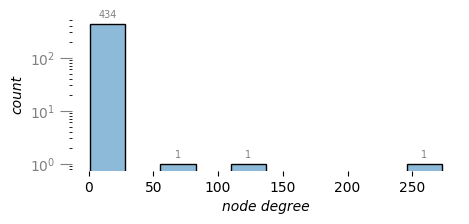

In [20]:
fig, ax = plt.subplots(figsize = (5, 2))
plt.rcParams["font.family"] = "sans-serif"

y = sns.histplot(node_degree)
y.tick_params(axis = "y", size = 9, colors = "gray")
y.bar_label(y.containers[0], padding = 3, color = "gray", fontsize = 7)

plt.xlabel("node degree", size = 10, fontstyle = "italic")
plt.ylabel("count", size = 10, fontstyle = "italic")

sns.despine(bottom = True, left = True)
plt.yscale("log")

plt.legend([], [], frameon = False);

In [21]:
for node_id in graph.nodes():
    graph.nodes[node_id]["volume"] = 0
    graph.nodes[node_id]["credits"] = 0
    graph.nodes[node_id]["debits"] = 0

for index, row in df_summary.iterrows():
    src_id: int = row["src_id"]
    dst_id: int = row["dst_id"]
    amount: float = float(row["total_amount"])

    graph.nodes[src_id]["volume"] += amount
    graph.nodes[src_id]["debits"] += amount

    graph.nodes[dst_id]["volume"] += amount
    graph.nodes[dst_id]["credits"] += amount

for node_id in graph.nodes():
    graph.nodes[node_id]["balance"] = graph.nodes[node_id]["credits"] - graph.nodes[node_id]["debits"]

In [22]:
nodes_dat: typing.List[ dict ] = [
    dat
    for _, dat in graph.nodes(data = True)
]

df_nodes: pd.DataFrame = pd.DataFrame.from_dict(
    nodes_dat,
    orient = "columns"
)

df_nodes.head()

,name,value,size,degree,volume,credits,debits,balance
0,AZARBAYCAN METANOL KOMPANI MMC,0.000000,10,1,1.511916e+06,0.000000e+00,1511916.50,-1.511916e+06
1,LCM ALLIANCE LLP,0.001608,10,273,7.926534e+08,7.842097e+08,8443707.00,7.757660e+08
2,SKN ELECTRICAL SERVICES LIMITEDACCO,0.000000,10,1,1.100632e+05,0.000000e+00,110063.19,-1.100632e+05
3,METASTAR INVEST LLP,0.000546,10,134,4.236822e+08,3.498216e+08,73860598.00,2.759610e+08
4,INMAXO CAPITAL CORP.,0.000000,10,1,4.152311e+05,0.000000e+00,415231.08,-4.152311e+05


In [23]:
df_nodes.describe()

,value,size,degree,volume,credits,debits,balance
count,437.000000,437.0,437.000000,4.370000e+02,4.370000e+02,4.370000e+02,4.370000e+02
mean,0.000008,10.0,2.205950,1.339759e+07,6.698797e+06,6.698797e+06,-1.909531e-09
std,0.000094,0.0,14.766024,1.111983e+08,8.234222e+07,7.045104e+07,1.054614e+08
min,0.000000,10.0,1.000000,0.000000e+00,0.000000e+00,0.000000e+00,-1.452793e+09
25%,0.000000,10.0,1.000000,0.000000e+00,0.000000e+00,0.000000e+00,-1.313250e+06
50%,0.000000,10.0,1.000000,4.128350e+03,0.000000e+00,4.128350e+03,0.000000e+00
75%,0.000000,10.0,1.000000,1.425239e+06,0.000000e+00,1.425239e+06,0.000000e+00
max,0.001608,10.0,273.000000,1.538163e+09,1.458096e+09,1.452793e+09,1.378030e+09


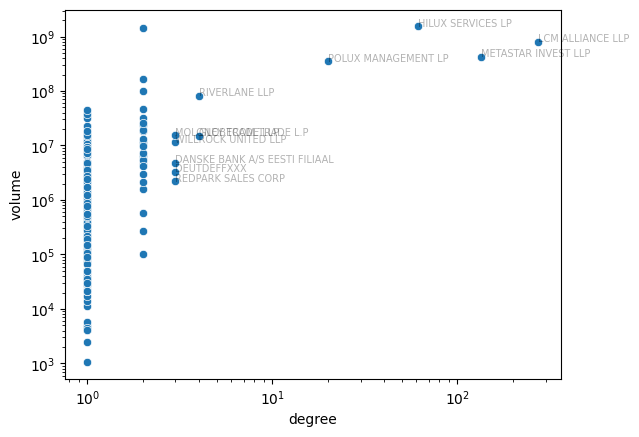

In [24]:
x: list = df_nodes["degree"].to_list()
y: list = df_nodes["volume"].to_list()
labels: list = df_nodes["name"].to_list()

sns.scatterplot(data = df_nodes, x = "degree", y = "volume")

plt.yscale("log")
plt.xscale("log")

for i, label in enumerate(labels):
    if x[i] > 2:
        plt.annotate(label, (x[i], y[i]), alpha = 0.3, fontsize = 7)

plt.show()

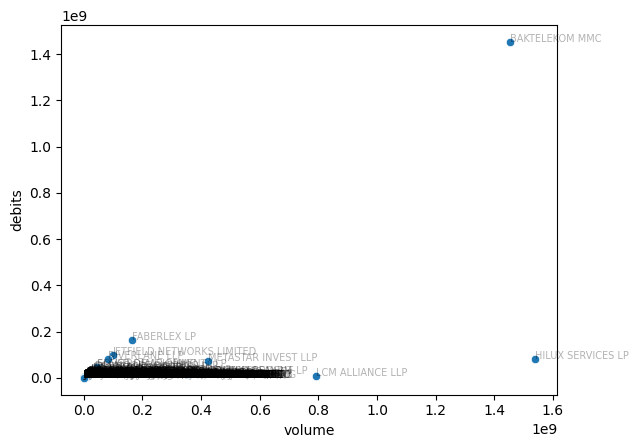

In [25]:
x: list = df_nodes["volume"].to_list()
y: list = df_nodes["debits"].to_list()
labels: list = df_nodes["name"].to_list()

sns.scatterplot(data = df_nodes, x = "volume", y = "debits")

for i, label in enumerate(labels):
    plt.annotate(label, (x[i], y[i]), alpha = 0.3, fontsize = 7)

plt.show()

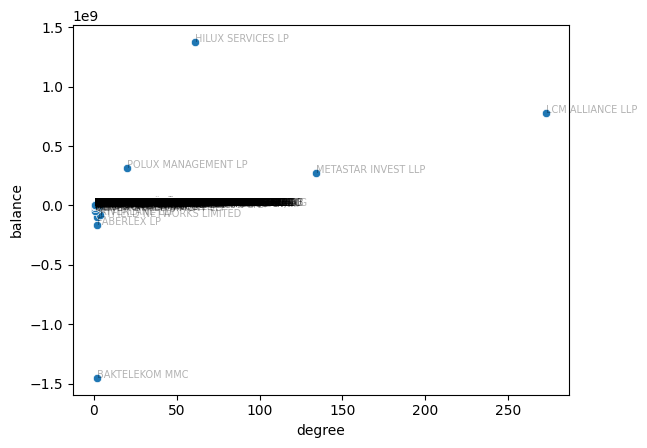

In [26]:
x: list = df_nodes["degree"].to_list()
y: list = df_nodes["balance"].to_list()
labels: list = df_nodes["name"].to_list()

sns.scatterplot(data = df_nodes, x = "degree", y = "balance")

for i, label in enumerate(labels):
    plt.annotate(label, (x[i], y[i]), alpha = 0.3, fontsize = 7)

plt.show()

insights:
  * a sparse graph
  * not wide, diameter = 4
  * power law distribution on node degree
  * the funds appear to have sourced mostly through "BAKTELEKOM MMC", then drained through "LCM", "HILUX", "POLUX", and "METASTAR"

## components and paths

In [27]:
for clique in nx.connected_components(graph.to_undirected()):
    print(clique)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

In [28]:
path_counts: typing.List[ int ] = [
    len(path[1]) + 1
    for path in nx.all_pairs_all_shortest_paths(graph)
]

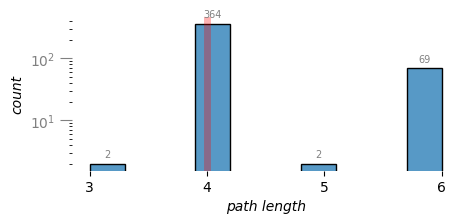

In [29]:
fig, ax = plt.subplots(figsize = (5, 2))
plt.rcParams["font.family"] = "sans-serif"

y = sns.histplot(path_counts)
y.tick_params(axis = "y", size = 9, colors = "gray")
y.bar_label(y.containers[0], padding = 3, color = "gray", fontsize = 7)

plt.xlabel("path length", size = 10, fontstyle = "italic")
plt.ylabel("count", size = 10, fontstyle = "italic")

plt.axvline(x = statistics.median(path_counts), color = "red", lw = 5, alpha = 0.3)

plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x)))
y.set(xticks = range(min(path_counts), max(path_counts) + 1))

sns.despine(bottom = True, left = True)
plt.yscale("log")

plt.legend([], [], frameon = False);

insights:

  * fully connected graph, avg path length = 4

## triadic census

In [30]:
for triad, occurrences in sorted(nx.triadic_census(graph).items(), key = lambda x: x[1], reverse = True):
    if occurrences > 0:
        print(f"triad {triad:>5}: {occurrences:7d} occurrences")

triad   003: 13652536 occurrences
triad   012:  113313 occurrences
triad  021U:   46815 occurrences
triad   102:     425 occurrences
triad  111D:     411 occurrences
triad  120D:      33 occurrences
triad  021D:      19 occurrences
triad  021C:      15 occurrences
triad  030T:       2 occurrences
triad  111U:       1 occurrences


<img
 src="https://figures.semanticscholar.org/6ebe86cdf25f3b58dd98dd9c1c00c3f5c2491734/2-Figure1-1.png"
 style="height:500px"
/>

insights:

  * do the many `021U` triads indicate "burst in beneficiaries" AML tradecraft pattern?

## flow analysis

In [31]:
nx.flow_hierarchy(graph)

0.9896265560165975

In [32]:
for node_id in nx.center(graph.to_undirected()):
    print(node_id, graph.nodes[node_id])

17 {'name': 'GLOBECOM TRADE L.P', 'value': 0.0, 'size': 10, 'degree': 4, 'volume': 15165112.0, 'credits': 0, 'debits': 15165112.0, 'balance': -15165112.0}
66 {'name': 'RIVERLANE LLP', 'value': 0.0, 'size': 10, 'degree': 4, 'volume': 82016410.99000001, 'credits': 0, 'debits': 82016410.99000001, 'balance': -82016410.99000001}


In [33]:
pos_bal: int = 0
neg_bal: int = 0
zed_bal: int = 0

for node_id in nx.periphery(graph.to_undirected()):
    dat: dict = graph.nodes[node_id]

    if dat["balance"] > 0:
        pos_bal += 1
    elif dat["balance"] < 0:
        neg_bal += 1
    else:
        zed_bal += 1

ic(pos_bal, neg_bal, zed_bal);

ic| pos_bal: 0, neg_bal: 208, zed_bal: 215


In [34]:
len(graph.nodes)

437

In [35]:
len(list(nx.periphery(graph.to_undirected())))

423

In [36]:
non_periph: set = set(graph.nodes) - set(nx.periphery(graph.to_undirected()))

details: dict = {
    node_id: graph.nodes[node_id]
    for node_id in non_periph
}

for node_id, dat in sorted(details.items(), key = lambda pair: pair[1]["value"], reverse = True):
    print(f"{node_id:3}", dat)

  1 {'name': 'LCM ALLIANCE LLP', 'value': 0.001608140883686597, 'size': 10, 'degree': 273, 'volume': 792653368.8799999, 'credits': 784209661.8799999, 'debits': 8443707.0, 'balance': 775765954.8799999}
302 {'name': 'HILUX SERVICES LP', 'value': 0.0007487082146999895, 'size': 10, 'degree': 61, 'volume': 1538162666.2199998, 'credits': 1458096291.0399997, 'debits': 80066375.18, 'balance': 1378029915.8599997}
298 {'name': 'POLUX MANAGEMENT LP', 'value': 0.0006880733944954129, 'size': 10, 'degree': 20, 'volume': 352811832.13, 'credits': 335246788.13, 'debits': 17565044.0, 'balance': 317681744.13}
  3 {'name': 'METASTAR INVEST LLP', 'value': 0.0005457133818411895, 'size': 10, 'degree': 134, 'volume': 423682242.37999994, 'credits': 349821644.3799999, 'debits': 73860598.0, 'balance': 275961046.3799999}
 66 {'name': 'RIVERLANE LLP', 'value': 0.0, 'size': 10, 'degree': 4, 'volume': 82016410.99000001, 'credits': 0, 'debits': 82016410.99000001, 'balance': -82016410.99000001}
  7 {'name': 'DANSKE BA

let's keep track of these intermediary nodes in particular, which don't rank as high in centrality -- what is flowing through them?

In [37]:
intermed: typing.Set[ int ] = non_periph - set([ 1, 302, 298, 3, ])

insights:

  * nodes in the periphery are split between negative balance (initial sources for funds) and zero balance (intermediaries to hide eventual end outflows) though none end with a positive balance

  * 10 intermediary nodes don't rank as high in centrality as the 4 main shell companies mentioned in the investigative journalism articles
     * these 10 are in the computed "center" of the graph
     * what patterns of transactions flow through these?

## directed flows

In [38]:
for node_id in graph.nodes():
    deg: int = graph.in_degree(node_id)

    if deg > 0:
        dat = graph.nodes[node_id]
        print(f"{deg:3} in degree {node_id:3}", dat["name"])

272 in degree   1 LCM ALLIANCE LLP
132 in degree   3 METASTAR INVEST LLP
 18 in degree 298 POLUX MANAGEMENT LP
 60 in degree 302 HILUX SERVICES LP


In [39]:
for node_id in graph.nodes():
    graph.nodes[node_id]["out_deg"] = graph.out_degree(node_id)

In [40]:
flows_dat: list = [
    {
        "node_id": node_id,
        "name": dat["name"],
        "out_deg": dat["out_deg"],
        "balance": dat["balance"],
        "volume": dat["volume"],
        "credits": dat["credits"],
        "debits": dat["debits"],
    }
    for node_id, dat in graph.nodes(data = True)
    if dat["out_deg"] > 0
]

df_flows: pd.DataFrame = pd.DataFrame.from_dict(
    flows_dat,
    orient = "columns"
)

df_flows.head()

,node_id,name,out_deg,balance,volume,credits,debits
0,0,AZARBAYCAN METANOL KOMPANI MMC,1,-1.511916e+06,1.511916e+06,0.000000e+00,1511916.50
1,1,LCM ALLIANCE LLP,1,7.757660e+08,7.926534e+08,7.842097e+08,8443707.00
2,2,SKN ELECTRICAL SERVICES LIMITEDACCO,1,-1.100632e+05,1.100632e+05,0.000000e+00,110063.19
3,3,METASTAR INVEST LLP,2,2.759610e+08,4.236822e+08,3.498216e+08,73860598.00
4,4,INMAXO CAPITAL CORP.,1,-4.152311e+05,4.152311e+05,0.000000e+00,415231.08


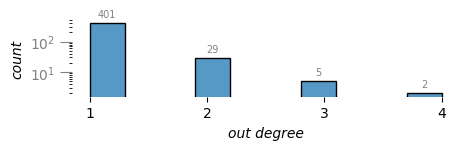

In [41]:
dat = df_flows["out_deg"].to_list()

fig, ax = plt.subplots(figsize = (5, 1))
plt.rcParams["font.family"] = "sans-serif"

y = sns.histplot(dat)
y.tick_params(axis = "y", size = 9, colors = "gray")
y.bar_label(y.containers[0], padding = 3, color = "gray", fontsize = 7)

plt.xlabel("out degree", size = 10, fontstyle = "italic")
plt.ylabel("count", size = 10, fontstyle = "italic")

plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x)))
y.set(xticks = range(min(dat), max(dat) + 1))

sns.despine(bottom = True, left = True)
plt.yscale("log")

plt.legend([], [], frameon = False);

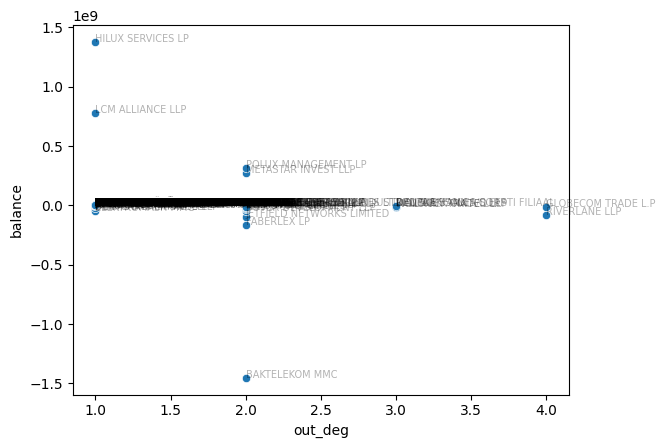

In [42]:
x: list = df_flows["out_deg"].to_list()
y: list = df_flows["balance"].to_list()
labels: list = df_flows["name"].to_list()

sns.scatterplot(data = df_flows, x = "out_deg", y = "balance")

for i, label in enumerate(labels):
    plt.annotate(label, (x[i], y[i]), alpha = 0.3, fontsize = 7)

plt.show()

here are the shell companies which had more funds transferred out than transferred in

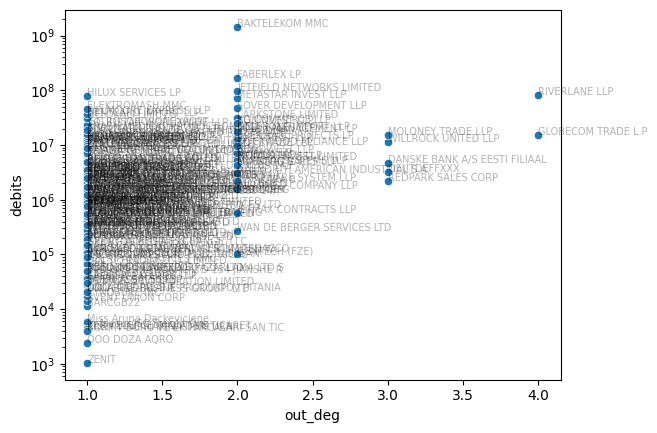

In [43]:
x: list = df_flows["out_deg"].to_list()
y: list = df_flows["debits"].to_list()
labels: list = df_flows["name"].to_list()

sns.scatterplot(data = df_flows, x = "out_deg", y = "debits")

for i, label in enumerate(labels):
    plt.annotate(label, (x[i], y[i]), alpha = 0.3, fontsize = 7)

plt.yscale("log")
plt.show()

## summary

take-aways:

 * this is a relatively sparse graph with `diameter = 4`
 * power law distribution on node degree, `max node degree = 273`
 * fully connected, `avg path length = 4`
 * 423 nodes of 437 total are in the periphery, while 10 are in the computed "center"
 * periphery nodes split between negative balance (multiple sources for funds) and zero balance (intermediaries to hide the eventual end outflows); none end with a positive balance

questions:

 * do the many `021U` triads indicate "burst in beneficiaries" AML tradecraft patterns?

OCCRP analysis and the subsequent investigative journalism articles mention the 4 top shell companies involved in the "Azerbaijani Laundromat", in order of centrality: "LCM", "HILUX", "POLUX", "METASTAR". 

`NetworkX` identifies 423 nodes out of a 437 total as "peripheral", so then what kind of patterns occur involving the other intermediate shell companies?

The remaining 10 shell companies of interest about tradecraft patterns are located approximately at the computed "center" of the graph:

  * "DANSKE BANK A/S EESTI FILIAAL"
  * "RIVERLANE LLP"
  * "GLOBECOM TRADE L.P"
  * "MOLONEY TRADE LLP"
  * "DEUTDEFFXXX"
  * "WILLROCK UNITED LLP"
  * "HARDWARE SYSTEM LLP"
  * "BONDWEST LLP"
  * "DELFRONT IMPORT LLP"
  * "REDPARK SALES CORP"

Note that the leaked transaction data came from an Estonian branch of Danske Bank, which is one of these intermediary nodes identified: "DANSKE BANK A/S EESTI FILIAAL" https://thebanks.eu/banks/13002

These intermediaries appear to be where initial inflows of funds primarily were sourced?

Orders of magnitude larger amounts of funds appear to have sourced into "BAKTELEKOM MMC" plus another ~200 companies in the periphery (to a lesser extent) then drained mostly out of "LCM", "HILUX", "POLUX", and "METASTAR"